# Interpreting Identity

# Setup
(No need to read)

In [1]:
TRAIN_MODEL = False

In [2]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
import os

DEVELOPMENT_MODE = True
IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")
    ipython.magic("pip install ipympl")
    ipython.magic("pip install scipy")

if IN_COLAB or IN_GITHUB:
    %pip install transformer_lens
    %pip install circuitsvis
    %pip install ipympl

Running as a Jupyter notebook - intended for development only!


/tmp/ipykernel_9028/1878011034.py:22: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_9028/1878011034.py:23: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")
/tmp/ipykernel_9028/1878011034.py:24: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("pip install ipympl")



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_9028/1878011034.py:25: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("pip install scipy")



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: notebook_connected


In [4]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [5]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import os
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [6]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


device = "cuda" if torch.cuda.is_available() else "cpu"

Plotting helper functions:

In [7]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [8]:
# Define the location to save the model, using a relative path
PTH_LOCATION = "workspace/_scratch/identity.pth"

# Create the directory if it does not exist
os.makedirs(Path(PTH_LOCATION).parent, exist_ok=True)

# Model Training

## Config

In [9]:
p = 3
frac_train = 1

# Optimizer config
lr = 1e-3
wd = 1e-2
betas = (0.9, 0.999)

num_epochs = 20000
checkpoint_every = 200

DATA_SEED = 598

## Define Task
* Define modular addition
* Define the dataset & labels

Input format:
|a|=|

In [10]:
a_vector = torch.arange(p)
equals_vector = einops.repeat(torch.tensor(p), " -> i", i=p)


In [11]:
dataset = torch.stack([a_vector, equals_vector], dim=1).to(device)
print(dataset)
print(dataset.shape)

tensor([[0, 3],
        [1, 3],
        [2, 3]], device='cuda:0')
torch.Size([3, 2])


In [12]:
labels = dataset[:, 0]
print(labels.shape)
print(labels)

torch.Size([3])
tensor([0, 1, 2], device='cuda:0')


Convert this to a train + test set - 30% in the training set

In [13]:
torch.manual_seed(DATA_SEED)
indices = torch.randperm(p)
cutoff = int(p*frac_train)
train_indices = indices[:cutoff]
test_indices = indices[cutoff:]

train_data = dataset[train_indices]
train_labels = labels[train_indices]
test_data = dataset[test_indices]
test_labels = labels[test_indices]
print(train_data)
print(train_labels)
print(train_data.shape)
print(test_data[:5])
print(test_labels[:5])
print(test_data.shape)

tensor([[2, 3],
        [0, 3],
        [1, 3]], device='cuda:0')
tensor([2, 0, 1], device='cuda:0')
torch.Size([3, 2])
tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)
tensor([], device='cuda:0', dtype=torch.int64)
torch.Size([0, 2])


## Define Model

In [14]:
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 1,
    d_model = 2,
    d_head = 2,
    d_mlp = 0,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=p+1,
    d_vocab_out=p,
    n_ctx=2,
    init_weights=True,
    device=device,
    seed = 999,
)
model = HookedTransformer(cfg)
for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False

Disable the biases, as we don't need them for this task and it makes things easier to interpret.

## Define Optimizer + Loss

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)
def loss_fn(logits, labels):
    if len(logits.shape)==3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()
train_logits = model(train_data)
train_loss = loss_fn(train_logits, train_labels)
print(train_loss)
test_logits = model(test_data)
test_loss = loss_fn(test_logits, test_labels)
print(test_loss)
print("Uniform loss:")
print(np.log(p))

tensor(1.1084, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(nan, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Uniform loss:
1.0986122886681098


## Actually Train

**Weird Decision:** Training the model with full batch training rather than stochastic gradient descent. We do this so to make training smoother and reduce the number of slingshots.

In [16]:
train_losses = []
test_losses = []
model_checkpoints = []
checkpoint_epochs = []
if TRAIN_MODEL:
    for epoch in tqdm.tqdm(range(num_epochs)):
        train_logits = model(train_data)
        train_loss = loss_fn(train_logits, train_labels)
        train_loss.backward()
        train_losses.append(train_loss.item())

        optimizer.step()
        optimizer.zero_grad()

        with torch.inference_mode():
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_labels)
            test_losses.append(test_loss.item())

        if ((epoch+1)%checkpoint_every)==0:
            checkpoint_epochs.append(epoch)
            model_checkpoints.append(copy.deepcopy(model.state_dict()))
            print(f"Epoch {epoch} Train Loss {train_loss.item()} Test Loss {test_loss.item()}")

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 199 Train Loss 0.8589038281202012 Test Loss nan
Epoch 399 Train Loss 0.4650000646824933 Test Loss nan
Epoch 599 Train Loss 0.1085971970928081 Test Loss nan
Epoch 799 Train Loss 0.021850534954020617 Test Loss nan
Epoch 999 Train Loss 0.009088972616683613 Test Loss nan
Epoch 1199 Train Loss 0.005009173392098151 Test Loss nan
Epoch 1399 Train Loss 0.0031815165049799464 Test Loss nan
Epoch 1599 Train Loss 0.0022001086522834413 Test Loss nan
Epoch 1799 Train Loss 0.001609729719530459 Test Loss nan
Epoch 1999 Train Loss 0.0012257751485579716 Test Loss nan
Epoch 2199 Train Loss 0.0009614633824639313 Test Loss nan
Epoch 2399 Train Loss 0.0007714575877380221 Test Loss nan
Epoch 2599 Train Loss 0.0006301553800941455 Test Loss nan
Epoch 2799 Train Loss 0.000522141536283172 Test Loss nan
Epoch 2999 Train Loss 0.0004376973663692452 Test Loss nan
Epoch 3199 Train Loss 0.00037045825071000684 Test Loss nan
Epoch 3399 Train Loss 0.00031603599729488854 Test Loss nan
Epoch 3599 Train Loss 0.0002714

In [17]:
if TRAIN_MODEL:
    torch.save(
        {
            "model":model.state_dict(),
            "config": model.cfg,
            "checkpoints": model_checkpoints,
            "checkpoint_epochs": checkpoint_epochs,
            "test_losses": test_losses,
            "train_losses": train_losses,
            "train_indices": train_indices,
            "test_indices": test_indices,
        },
        PTH_LOCATION)

In [18]:
if not TRAIN_MODEL:
    cached_data = torch.load(PTH_LOCATION)
    model.load_state_dict(cached_data['model'])
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    train_indices = cached_data["train_indices"]
    test_indices = cached_data["test_indices"]

# Look at weights

## Embedding weights

In [41]:
from scipy.linalg import qr

print(model.embed.W_E.data)
print(model.embed.W_E.data.shape)

W_E = model.embed.W_E.data.cpu().numpy()
pos = model.W_E_pos.data.cpu().numpy()
for i in range(W_E.shape[0]):
    print(f"Norm of token {i}: {np.linalg.norm(W_E[i])}")
    index = (4 if i < 3 else 5)
    print(f"Embedding: {pos[index]}")
    W_E[i] += pos[index]


# Create a matrix with tensor[0] as the first column
ttr = W_E.transpose()
print(ttr)

# Perform QR decomposition to obtain an orthonormal matrix
Q, R = qr(ttr)

print("Q: ", Q)
print("R: ", R)
print(np.matmul(Q, R))

def get_angle(a, b):
    return np.arccos(
        np.dot(a, b)
        / (np.linalg.norm(a) * np.linalg.norm(b))
    ) / np.pi * 180

dot_product = np.dot(W_E[0], W_E[3])
print(dot_product, get_angle(W_E[0], W_E[3]))
product2 = np.dot(R[:, 0], R[:, 3])
print(product2, get_angle(R[:, 0], R[:, 3]))

tensor([[-2.0527,  1.1695],
        [-0.9373, -1.3022],
        [ 1.3657,  1.4691],
        [-0.3344,  0.5091]], device='cuda:0')
torch.Size([4, 2])
Norm of token 0: 2.3624651432037354
Embedding: [-1.4751859   0.59753066]
Norm of token 1: 1.6044034957885742
Embedding: [-1.4751859   0.59753066]
Norm of token 2: 2.005875587463379
Embedding: [-1.4751859   0.59753066]
Norm of token 3: 0.6091135144233704
Embedding: [-0.1680884  -0.14457619]
[[-3.527852   -2.4124618  -0.10946131 -0.50251186]
 [ 1.767062   -0.7046308   2.0666573   0.36452132]]
Q:  [[-0.894109    0.44784927]
 [ 0.44784927  0.8941091 ]]
R:  [[ 3.945662    1.8414354   1.0234212   0.612551  ]
 [ 0.         -1.7104361   1.7987949   0.10087225]]
[[-3.527852   -2.4124615  -0.10946113 -0.5025118 ]
 [ 1.7670618  -0.7046309   2.0666573   0.3645213 ]]
2.4169192 9.351306761539192
2.4169192 9.35128627097168


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


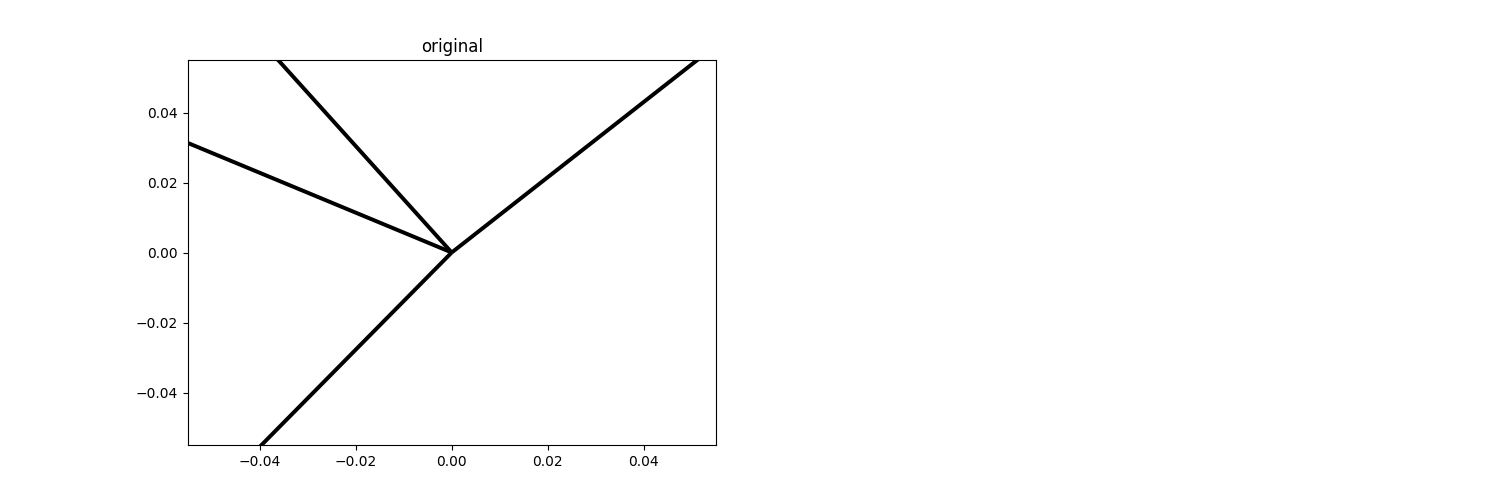

In [51]:
import matplotlib.pyplot as plt
import numpy as n

%matplotlib widget

plt.close('all')

def plot_tensor(fig, tensor, position = 111, title = ""):
    ax = fig.add_subplot(position)
    ax.set_title(title)

    # Define the origin
    origin = np.zeros((4, 2))

    # Plot the arrows
    for i in range(tensor.shape[0]):
        ax.quiver(origin[i, 0], origin[i, 1], 
                tensor[i, 0], tensor[i, 1],
                angles='xy', scale_units='xy', scale=1)

        ax.text(tensor[i, 0], tensor[i, 1], f"Embedding {i}", color='red')
    W_Q = model.blocks[0].attn.W_Q.data[0]
    W_K = model.blocks[0].attn.W_K.data[0].transpose(0, 1)
    W_QK = torch.matmul(W_Q, W_K)
    U, S, V = np.linalg.svd(W_QK.cpu())
    print("U=", U, "\nS=", S, "\nV=", V)
    
    ax.quiver(origin[i, 0], origin[i, 1], U[0, 0], U[0, 1], angles='xy', scale_units='xy', scale=1, color='blue')
    ax.text(U[0, 0], U[0, 1], f"U", color='blue')
    ax.quiver(origin[i, 0], origin[i, 1], V[0, 0], V[0, 1], angles='xy', scale_units='xy', scale=1, color='blue')
    ax.text(V[0, 0], V[0, 1], f"V", color='blue')

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(min(tensor[:, 0].min(), 0)*1.2, max(tensor[:, 0].max(), 0) * 1.2)
    ax.set_aspect('equal')
    ax.set_ylim(min(tensor[:, 1].min(), 0)*1.2, max(tensor[:, 1].max(), 0) * 1.2)

fig = plt.figure(figsize=(15, 5))
plot_tensor(fig, W_E, 121, "original")
plot_tensor(fig, R.transpose(), 122, "rotated")
plt.show()

# Unembedding weights

In [21]:
W_U = model.unembed.W_U.data.cpu().numpy()

print(W_U)

Qrev, Rrev = qr(W_U)

print("Q_U=", Qrev)
print("R_U=", Rrev)

print("W_E=", W_E)
print("W_U=", W_U)

product = np.matmul(W_E, W_U)
print(product)

rank = np.linalg.matrix_rank(product)
print(rank)

[[-1.387955  -1.6141683  0.9912386]
 [ 0.8615358 -1.6861373  1.8115926]]
Q_U= [[-0.8496274   0.5273834 ]
 [ 0.5273834   0.84962744]]
R_U= [[ 1.6336043   0.48220074  0.11322039]
 [ 0.         -2.283874    2.0619416 ]]
W_E= [[-2.0526662   1.1695312 ]
 [-0.937276   -1.3021615 ]
 [ 1.3657246   1.4691266 ]
 [-0.33442342  0.5090975 ]]
W_U= [[-1.387955  -1.6141683  0.9912386]
 [ 0.8615358 -1.6861373  1.8115926]]
[[ 3.8566012   1.3413585   0.08403206]
 [ 0.17903817  3.7085443  -3.2880502 ]
 [-0.6298591  -4.6816587   4.015218  ]
 [ 0.9027704  -0.31859267  0.59078383]]
2


# Activations

In [22]:
input = torch.tensor([[0,3], [1,3], [2,3]])
logits, cache = model.run_with_cache(input)
print(logits)

tensor([[[ 27.1331,   6.5226,   3.2225],
         [ 21.7257,   4.0041,   3.6805]],

        [[ 11.6829,  32.9373, -25.8135],
         [  9.7816,  27.1825, -21.2564]],

        [[  8.0685, -29.7456,  29.5645],
         [  6.9838, -24.7904,  24.7266]]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [23]:
print(logits)

tensor([[[ 27.1331,   6.5226,   3.2225],
         [ 21.7257,   4.0041,   3.6805]],

        [[ 11.6829,  32.9373, -25.8135],
         [  9.7816,  27.1825, -21.2564]],

        [[  8.0685, -29.7456,  29.5645],
         [  6.9838, -24.7904,  24.7266]]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [24]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post']

In [25]:
cache.cache_dict['hook_embed']

tensor([[[-2.0527,  1.1695],
         [-0.3344,  0.5091]],

        [[-0.9373, -1.3022],
         [-0.3344,  0.5091]],

        [[ 1.3657,  1.4691],
         [-0.3344,  0.5091]]], device='cuda:0')

In [50]:
W_K = model.blocks[0].attn.W_K.data[0].cpu()
W_Q = model.blocks[0].attn.W_Q.data[0].cpu()
print("W_K: ", W_K)
W_K_T = torch.transpose(W_K, 0, 1)
W_QK = torch.matmul(W_Q, W_K_T)
print("W_Q: ", W_Q)
print("W_K transposed: ", W_K_T)
print(W_QK)
W_V = model.blocks[0].attn.W_V.data[0].cpu()
W_O = model.blocks[0].attn.W_O.data[0].cpu()
W_VO = torch.matmul(W_V, W_O)
print(W_VO)
W_E = model.embed.W_E.data.cpu().numpy()
U, S, V = np.linalg.svd(W_QK)
print("U: ", U)
print("S: ", S)
print("V: ", V)
S_rank_1 = np.zeros((2, 2))
S_rank_1[0, 0] = S[0]
print("S_rank_1: ", S_rank_1)
W_QK_rank_1 = np.matmul(np.matmul(U, S_rank_1), V)
print("W_QK_rank_1: ", W_QK_rank_1)

W_K:  tensor([[ 1.5040,  1.9884],
        [-0.9069, -1.7974]])
W_Q:  tensor([[ 1.8223,  1.1761],
        [-1.5039, -1.4813]])
W_K transposed:  tensor([[ 1.5040, -0.9069],
        [ 1.9884, -1.7974]])
tensor([[ 5.0793, -3.7666],
        [-5.2072,  4.0264]])
tensor([[3.8114, 0.9125],
        [1.8140, 6.0918]])
U:  [[-0.6927834   0.72114575]
 [ 0.72114575  0.6927834 ]]
S:  [9.127106   0.09178303]
V:  [[-0.79696536  0.60402507]
 [ 0.60402507  0.79696536]]
S_rank_1:  [[9.12710571 0.        ]
 [0.         0.        ]]
W_QK_rank_1:  [[ 5.03929762 -3.8193154 ]
 [-5.24560487  3.97567697]]


In [ ]:
cache.cache_dict

{'hook_embed': tensor([[[-2.0527,  1.1695],
          [-0.3344,  0.5091]],
 
         [[-0.9373, -1.3022],
          [-0.3344,  0.5091]],
 
         [[ 1.3657,  1.4691],
          [-0.3344,  0.5091]]]),
 'hook_pos_embed': tensor([[[-1.4752,  0.5975],
          [-0.1681, -0.1446]],
 
         [[-1.4752,  0.5975],
          [-0.1681, -0.1446]],
 
         [[-1.4752,  0.5975],
          [-0.1681, -0.1446]]]),
 'blocks.0.hook_resid_pre': tensor([[[-3.5279,  1.7671],
          [-0.5025,  0.3645]],
 
         [[-2.4125, -0.7046],
          [-0.5025,  0.3645]],
 
         [[-0.1095,  2.0667],
          [-0.5025,  0.3645]]]),
 'blocks.0.attn.hook_q': tensor([[[[-9.0861, -6.7668]],
 
          [[-1.4639, -1.1310]]],
 
 
         [[[-3.3365, -1.7936]],
 
          [[-1.4639, -1.1310]]],
 
 
         [[[-3.3074, -3.1901]],
 
          [[-1.4639, -1.1310]]]]),
 'blocks.0.attn.hook_k': tensor([[[[ -6.9083, -10.1908]],
 
          [[ -1.0863,  -1.6544]]],
 
 
         [[[ -2.9893,  -3.5303]],
 
    